In [20]:
# Make the cells wider in the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
from numba import jit
from time import time
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

matplotlib.rc("figure", figsize=(16,3))
matplotlib.rc("lines", linewidth=2)
matplotlib.rc("font", serif='Computer Modern Roman')
# matplotlib.rc("title", fontsize=18)

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook is originally copied from WindForecast notebook. In it, we fit a Gaussian Process to the wind data to sample from to get scenarios for MPC. First, we fit a single GP directly to the data. Then, we'll match the original paper and fit a GP to the seasonal baseline and another GP to the residual.

# Run setup

In [16]:
# Run a setup script which defines some functions and constants for the MPC problems and what not
from mpc_util_functions import *

***

# Presceint MPC (optimal baseline)

100%|██████████| 2976/2976 [02:22<00:00, 20.84it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.04 MWh
Wind energy used:	167.81 MWh
Wind energy lost:	34.55 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1044.48


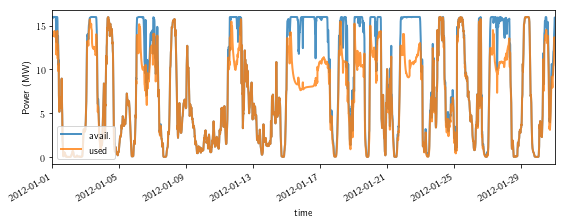

In [10]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, \
initial_storage_MPC, final_storage_MPC, \
final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(p_wind[sim_start_time+t:sim_start_time+t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -prescient_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_prescient_MPC)

# MPC no scenarios (vanilla forecaster from paper) 

100%|██████████| 2976/2976 [02:40<00:00, 20.97it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	40.53 MWh
Wind energy used:	150.96 MWh
Wind energy lost:	51.40 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1703.51


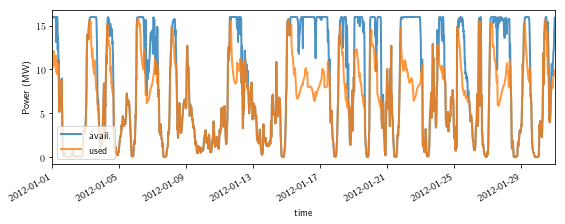

In [11]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def predict_wind(p_wind, baseline, autoreg_residual_params, t, M, L, K = 1):
    past = p_wind[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    pred += fut_baseline
    pred = np.maximum(wind_power_min, pred)
    pred = np.minimum(wind_power_max, pred)
    return pred

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    val_to_assign = np.matrix(np.concatenate([
        [p_wind[sim_start_time+t]],
        predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]])).T
        
#     print(type(val_to_assign))
#     print(val_to_assign.shape)
    wind_power_available_MPC.value = val_to_assign
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_AR_MPC, AR_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -AR_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -AR_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_AR_MPC)

# Robust MPC (from paper) 

In [12]:
T_MPC = intervals_per_day
K = 20

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)


def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
                           np.random.multivariate_normal(predict_wind(p_wind, baseline, 
                            autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
                             sigma_residual_errors, K)[:,:-1]])
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    

100%|██████████| 2976/2976 [27:57<00:00,  1.87it/s]   


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.07 MWh
Wind energy used:	166.81 MWh
Wind energy lost:	35.54 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1072.10


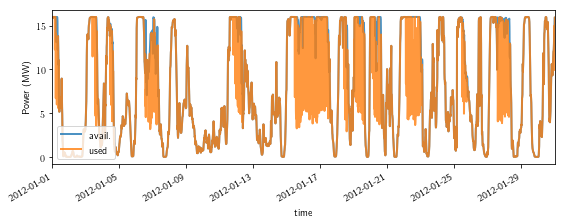

In [13]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

***

## Fitting a GP straight to train data - output is scalar

In [18]:
# data_dim = 20
data_dim = intervals_per_day

# First, we need to create the X matrix of training data which corresponds to the past 96 intervals of each point
N = train.shape[0]
X = np.zeros((N-data_dim, data_dim)) # subtract one_day because we don't have previous day data for first day
y = train.values[data_dim:]

for i in range(X.shape[0]):
    X[i,:] = train.values[i:(i+data_dim)]
    
# Limit the number of samples cause there's not enough memory to train on the whole training set
train_size = 5000
X = X[-train_size:, :]
y = y[-train_size:]


# Also create the test set:
# First, get all the points that are one day ahead of the points we're going to predict
tstart = pd.Timestamp(year=2011, month=12, day=31)
test_lags = p_wind[p_wind.index >= tstart]
# Drop the last point because we're not going to predict something using it
test_lags = test_lags[:-1]

X_test = np.zeros((test_lags.shape[0] - data_dim, data_dim))
for i in range(X_test.shape[0]):
    X_test[i,:] = test_lags.values[i:(i+data_dim)]
    
y_test = test.values

# Again, limit number of test points cause it takes a long time and memory to predict all of them
test_size = 2000
X_test = X_test[:test_size, :]
y_test = y_test[:test_size]

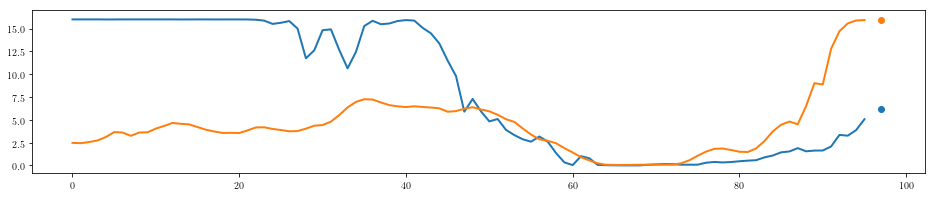

In [21]:
# Make sure the predicted points really are the points that come right after the points used as input for pred
test_pt = 487
plt.plot(X[test_pt,:])
plt.scatter(data_dim+1, y[test_pt])

plt.plot(X_test[test_pt,:])
plt.scatter(data_dim+1, y_test[test_pt]);

## Matern Kernel

**Fit scores for certain parameters:** 

Length scale, lower bound, upper bound, score <br>
With 5,000 training samples: <br>
96 dimensional data: <br>
1, 0.5, 40: 0.8336. length_scale=14.1 <br>
1, 0.5, 100: 0.8336 <br>
1, 0.5, 15: 0.8336 <br>

48 dimensional data: <br>
1, 0.5, 40: 0.1242 <br>

64 dimensional data: <br>
1, 0.5, 15: 0.7157. length_scale=5.91 <br>

196 dimensional data: <br>
1, 0.5, 100: 0.7027. Length scale 26.8


96 dimensional data, 10,000 training samples:<br>
1, 0.1, 30: 0.9145. Length_scale=14<br>


96 dim data, 5,000 training samples, now with factor of train_data_var / 2 on the kernel:
1, 0.1, 30: 0.9086, log-lik=-7728, Length scale=20.8<br>



In [22]:
# Try making a kernel, copy one from one of the examples from sklearn
train_data_var = np.var(train)
kern = train_data_var * (2/3) * kernels.Matern(length_scale=20, length_scale_bounds=(15, 25))

tic = time()
# tried n_optimizer = 4, took long time
matern_gp = GaussianProcessRegressor(kernel=kern, normalize_y=True, copy_X_train=False).fit(X,y) 
print("Time taken to train GP on %d samples of dimension %d: %.1f secs" % (train_size, data_dim, (time() - tic)))

fit_score = matern_gp.score(X_test, y_test)
print("Fit score on test set: %.4f" % fit_score)

log_lik = matern_gp.log_marginal_likelihood_value_
print("Log-likelihood of kernel theta: %.4f" % log_lik )

print("Kernel params to see what length scale it used")
matern_gp.kernel_.get_params

Time taken to train GP on 5000 samples of dimension 96: 133.2 secs
Fit score on test set: 0.9086
Log-likelihood of kernel theta: -7728.6482
Kernel params to see what length scale it used


<bound method KernelOperator.get_params of 2.9**2 * Matern(length_scale=20.8, nu=1.5)>

In [23]:
# First, look at the prediction of the test set
tic = time()
y_mean, y_std = matern_gp.predict(X_test, return_std=True)
print("Time taken to predict %i test samples: %.1f sec" % (X_test.shape[0], time()-tic))

Time taken to predict 2000 test samples: 8.7 sec


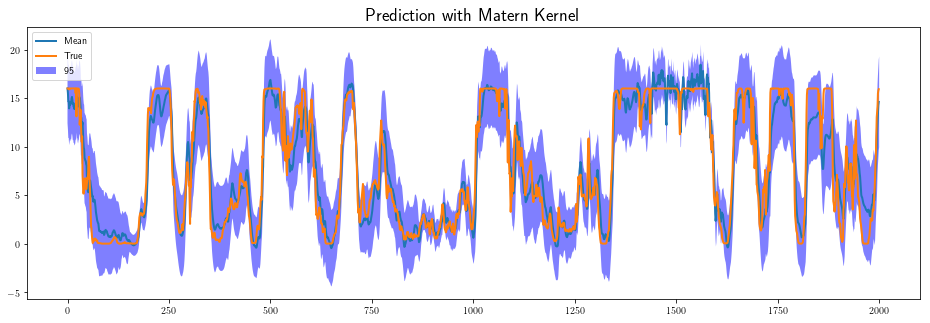

In [24]:
plt.figure(figsize=(16,5))
plt.plot(y_mean, label="Mean")
plt.plot(y_test, label="True")

# Plot the 95% confidence interval
vec = np.atleast_2d(np.linspace(0, len(y_mean), len(y_mean))).T
plt.fill(np.concatenate([vec, vec[::-1]]),
         np.concatenate([y_mean - 1.9600 * y_std,
                        (y_mean + 1.9600 * y_std)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval');
plt.title("Prediction with Matern Kernel", fontsize=18)
plt.legend(loc="upper left");

Note: this GP is setup so that it takes the previous day's values as input (so a vector) and then predicts only the next interval's value (so a scalar). One way to use this as a forecaster, then, is to iteratively use the predictions as input to a prediction for the next interval, since it only predicts one value at a time. That is NOT what is done to generate this plot. In this plot, the model is given as input the ACTUAL data from the past day and then predicts the next point, and this is done at every time step.

In [31]:
# Now, look at samples taken from the distribution
tic = time()
num_samps = 1
samps = matern_gp.sample_y(X_test, num_samps)
print("Time taken to sample %d scenarios:: %.1f secs" % (num_samps, time()-tic))

Time taken to sample 1 scenarios:: 8.6 secs


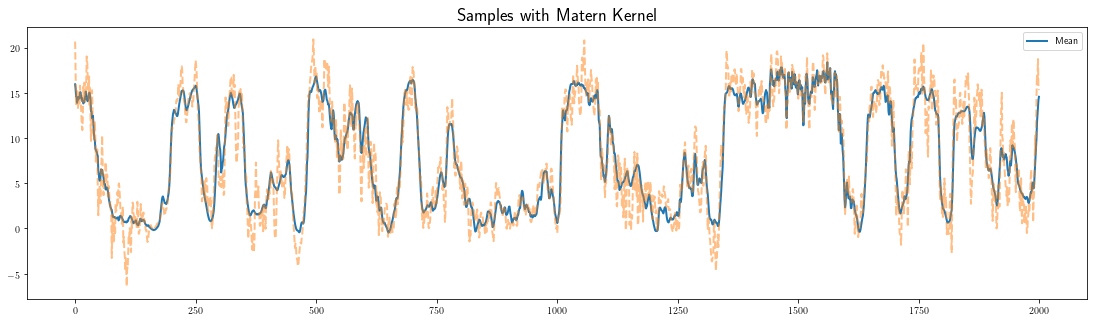

In [32]:
plt.figure(figsize=(19,5))
mean_line = plt.plot(y_mean)
for k in range(num_samps):
    plt.plot(samps[:,k], '--', alpha=0.5)
plt.title("Samples with Matern Kernel", fontsize=18)
plt.legend((mean_line), ('Mean',));

Note that because this particular GP only predicts one value into the future at a time, a "scenario" generated by this GP is not correlated with itself across time. Basically, scenarios generated by this method are pretty much just noise around the prediction rather than an entire vector sampled from a distribution where that vector would have correlations between its samples that match historical examples.

### MPC with Matern Kernel (version which predicts only one step into the future)

In this implementation, we use the same forecaster for the power as from the original paper (referred to as the vanilla forecaster), and then use the output of that forecaster as input to the GP in order to generate the scenarios. So, to be clear, the GP is not being used for forecasting purposes here, only scenario generation. 

In [33]:
T_MPC = intervals_per_day
K = 20 # Number of scenarios to sample

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

# Ahead of time, make an indexer which will quickly create the diced array without using a for loop
count_vec = np.arange(2*T_MPC)
indexer = np.zeros((T_MPC, T_MPC), dtype=np.int)
for i in range(indexer.shape[0]):
    indexer[i,:] = count_vec[i:i+T_MPC]
# Now, if you take an array and do arr[indexer], it'll return a matrix with strides taken from the array
# at steps of T_MPC. Assumes the arr is 2*T_MPC long

def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
    
    #### Logan's GP code ####
    # First, get the forecast for the next T_MPC intervals
    forecast = predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)
    # Then, combine that with data from the past T_MPC intervals and then dice it into a matrix
    # where each row is the past T_MPC values (real or predicted) leading up to a point. This will
    # be the input to the GP
    eval_data = np.concatenate((p_wind[sim_start_time+t-T_MPC:sim_start_time+t], forecast))
    N = eval_data.shape[0]
    gp_input = eval_data[indexer]
        
    # Get some samples of residuals from the GP
    samps = matern_gp.sample_y(gp_input, K)
    samps = samps.T
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T, 
                          samps[:,:-1]])
    
    #### Logan's GP code ####
    
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])

In [34]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [46:48<00:00,  1.09it/s] 


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	36.08 MWh
Wind energy used:	155.57 MWh
Wind energy lost:	46.79 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1517.68


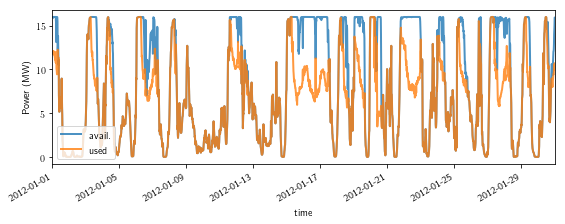

In [35]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

***

# RBF Kernel

**Fit scores for certain parameters:** 

Length scale, lower bound, upper bound, variance factor, score <br>
With 5,000 training samples: <br>
96 dimensional data: <br>
1, 0.5, 20, 1: 0.6915. length_scale=11.5 <br>
1, 0.5, 20, 1/2: 0.6915. length_scale=11.5 <br>
1, 0.5, 20, 1/4: 0.6915. length_scale=11.5 <br>


In [36]:
# Try making a kernel, copy one from one of the examples from sklearn
train_data_var = np.var(train)
kern = train_data_var * (1/4) * kernels.RBF(length_scale=1.0, length_scale_bounds=(0.5, 20))

tic = time()
# tried n_optimizer = 4, took long time
rbf_gp = GaussianProcessRegressor(kernel=kern, normalize_y=True, copy_X_train=False).fit(X,y) 
print("Time taken to train GP on %d samples of dimension %d: %.1f secs" % (train_size, data_dim, (time() - tic)))

fit_score = rbf_gp.score(X_test, y_test)
print("Fit score on test set: %.4f" % fit_score)

log_lik = rbf_gp.log_marginal_likelihood_value_
print("Log-likelihood of kernel theta: %.4f" % log_lik )

print("Kernel params to see what length scale it used")
rbf_gp.kernel_.get_params

Time taken to train GP on 5000 samples of dimension 96: 377.0 secs
Fit score on test set: 0.6915
Log-likelihood of kernel theta: -10133.7349
Kernel params to see what length scale it used


<bound method KernelOperator.get_params of 4.2**2 * RBF(length_scale=11.5)>

In [37]:
# First, look at the prediction of the test set
tic = time()
y_mean, y_std = rbf_gp.predict(X_test, return_std=True)
print("Time taken to predict %i test samples: %.1f sec" % (X_test.shape[0], time()-tic))

Time taken to predict 2000 test samples: 14.3 sec


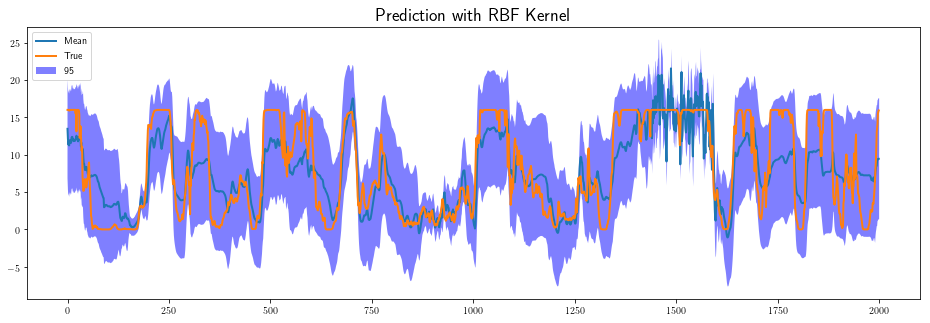

In [38]:
plt.figure(figsize=(16,5))
plt.plot(y_mean, label="Mean")
plt.plot(y_test, label="True")

# Plot the 95% confidence interval
vec = np.atleast_2d(np.linspace(0, len(y_mean), len(y_mean))).T
plt.fill(np.concatenate([vec, vec[::-1]]),
         np.concatenate([y_mean - 1.9600 * y_std,
                        (y_mean + 1.9600 * y_std)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval');
plt.title("Prediction with RBF Kernel", fontsize=18)
plt.legend(loc="upper left");

In [43]:
# Now, look at samples taken from the distribution
tic = time()
num_samps = 1
samps = rbf_gp.sample_y(X_test, num_samps)
print("Time taken to sample %d scenarios:: %.1f secs" % (num_samps, time()-tic))

Time taken to sample 1 scenarios:: 8.9 secs


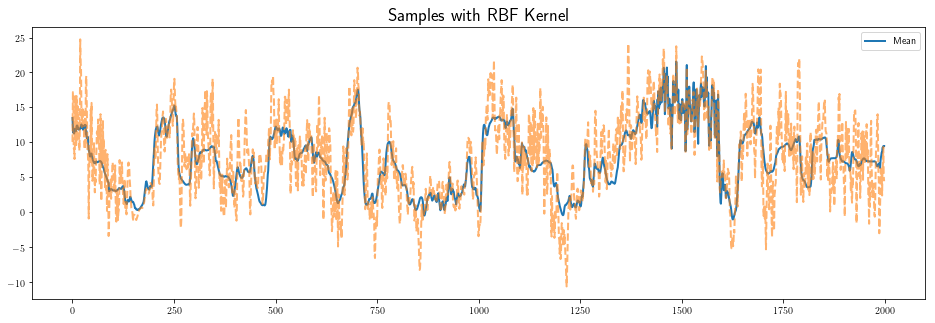

In [44]:
plt.figure(figsize=(16,5))
mean_line = plt.plot(y_mean)
for k in range(num_samps):
    plt.plot(samps[:,k], '--', alpha=0.6)
plt.title("Samples with RBF Kernel", fontsize=18)
plt.legend((mean_line), ('Mean',));

### MPC

In [45]:
T_MPC = intervals_per_day
K = 20 # Number of scenarios to sample

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

# Ahead of time, make an indexer which will quickly create the diced array without using a for loop
count_vec = np.arange(2*T_MPC)
indexer = np.zeros((T_MPC, T_MPC), dtype=np.int)
for i in range(indexer.shape[0]):
    indexer[i,:] = count_vec[i:i+T_MPC]
# Now, if you take an array and do arr[indexer], it'll return a matrix with strides taken from the array
# at steps of T_MPC. Assumes the arr is 2*T_MPC long

def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
    
    #### Logan's GP code ####
    # First, get the forecast for the next T_MPC intervals
    forecast = predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)
    # Then, combine that with data from the past T_MPC intervals and then dice it into a matrix
    # where each row is the past T_MPC values (real or predicted) leading up to a point. This will
    # be the input to the GP
    eval_data = np.concatenate((p_wind[sim_start_time+t-T_MPC:sim_start_time+t], forecast))
    N = eval_data.shape[0]
    gp_input = eval_data[indexer]
        
    # Get some samples of residuals from the GP
    samps = rbf_gp.sample_y(gp_input, K)
    samps = samps.T
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T, 
                          samps[:,:-1]])
    
    #### Logan's GP code ####
    
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])

In [46]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [33:43<00:00,  1.32it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	30.62 MWh
Wind energy used:	161.35 MWh
Wind energy lost:	41.01 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1291.22


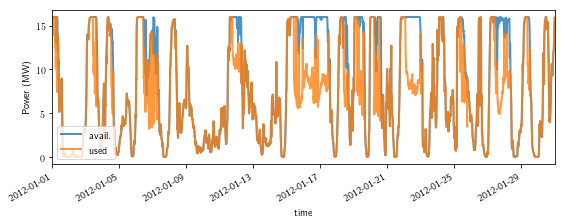

In [47]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

***

# Historical Residual Sampling

Instead of learning a distribution, just sample some historical residuals

In [50]:
T_MPC = intervals_per_day
K = 20 # Number of scenarios to sample

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

# Ahead of time, make an indexer which will quickly create the diced array without using a for loop
count_vec = np.arange(2*T_MPC)
indexer = np.zeros((T_MPC, T_MPC), dtype=np.int)
for i in range(indexer.shape[0]):
    indexer[i,:] = count_vec[i:i+T_MPC]
# Now, if you take an array and do arr[indexer], it'll return a matrix with strides taken from the array
# at steps of T_MPC. Assumes the arr is 2*T_MPC long

def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
    
    #### Logan's code ####
    # Get the forecast
    forecast = predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC).values
    
    # Get some residual samples from historical residuals
    samp_inds = np.random.randint(0, train_residuals.shape[0], size=20)
    resid_samps = train_residuals[samp_inds, :]
    
    # Add the residuals to the forecast to get the samples
    samps = resid_samps + forecast
    
    # Update the first col to be the same value like they do in the original code
    scenarios = np.hstack((np.matrix([p_wind[sim_start_time+t]]*K).T, samps[:,:-1]))

#     plt.plot(forecast)
#     for i in range(5):
#         plt.plot(np.array(scenarios)[i,:], linestyle='--', alpha=0.5)
#     plt.show()
    
    #### Logan's code ####
    
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    


In [51]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [27:20<00:00,  2.21it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	24.74 MWh
Wind energy used:	167.11 MWh
Wind energy lost:	35.24 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1058.04


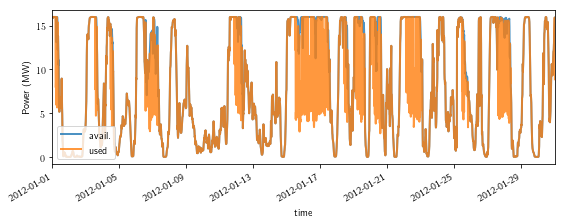

In [52]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

***

## Fitting a GP straight to train data - vector output
In this case, rather than make `y` a scalar value for each associated row in `X`, we make `y` a vector as well. This way, the GP will be learning to make a whole prediction into the future, rather than just a prediction of the power in the next time period. Then, using this model, we can use it as a forecaster (without having to do the iterative method we would need to for the GP models above which predict only a scalar of the next interval). We can also then sample from it multiple times in order to get scenarios. Thus, this method will no longer use the vanilla forecaster from the original paper.

In [53]:
# data_dim = 20
data_dim = intervals_per_day

# First, we need to create the X matrix of training data which corresponds to the past 96 intervals of each point
N = train.shape[0]
# subtract one_day because we don't have previous day data for first day and a second day because 
# we can't predict into data we don't have at the end
X = np.zeros((N-2*data_dim, data_dim)) 
y = np.zeros((X.shape[0], data_dim))
# y = train.values[data_dim:]

for i in range(X.shape[0]):
    X[i,:] = train.values[i:(i+data_dim)]
    y[i,:] = train.values[(i+data_dim):(i+2*data_dim)]
    
# Limit the number of samples cause there's not enough memory to train on the whole training set
train_size = 2000
X = X[-train_size:, :]
y = y[-train_size:, :]


# Also create the test set by doing basically all the same stuff:
N_test = test.shape[0]
# we don't need to subtract cause we have the training data, but easier to just ignore that single bit of data
X_test = np.zeros((N_test-2*data_dim, data_dim)) 
y_test = np.zeros((X_test.shape[0], data_dim))

for i in range(X_test.shape[0]):
    X_test[i,:] = test.values[i:(i+data_dim)]
    y_test[i,:] = test.values[(i+data_dim):(i+2*data_dim)]
    
# Limit the number of samples cause there's not enough memory to train on the whole training set
test_size = 1000
X_test = X_test[:test_size, :]
y_test = y_test[:test_size, :]

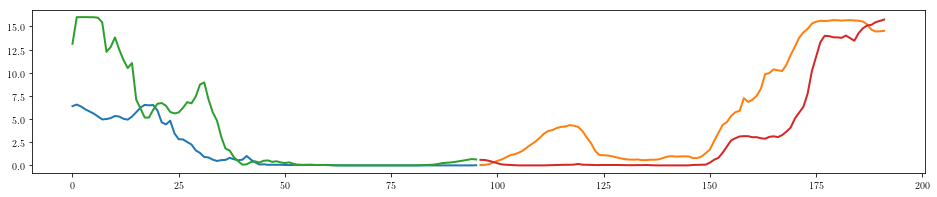

In [54]:
# Make sure the predicted points really are the points that come right after the points used as input for pred
test_pt = 22
plt.plot(np.arange(data_dim), X[test_pt,:])
plt.plot(range(data_dim, 2*data_dim), y[test_pt, :]);

plt.plot(np.arange(data_dim), X_test[test_pt,:])
plt.plot(range(data_dim, 2*data_dim), y_test[test_pt, :]);

## Matern Kernel

**Fit scores for certain parameters:** 


In [55]:
# Try making a kernel, copy one from one of the examples from sklearn
train_data_var = np.var(train)
kern = train_data_var * (2/3) * kernels.Matern(length_scale=1, length_scale_bounds=(1, 96))

tic = time()
# tried n_optimizer = 4, took long time
vec_matern_gp = GaussianProcessRegressor(kernel=kern, normalize_y=True, copy_X_train=False).fit(X,y) 
print("Time taken to train GP on %d samples of dimension %d: %.1f secs" % (train_size, data_dim, (time() - tic)))

fit_score = vec_matern_gp.score(X_test, y_test)
print("Fit score on test set: %.4f" % fit_score)

log_lik = vec_matern_gp.log_marginal_likelihood_value_
print("Log-likelihood of kernel theta: %.4f" % log_lik )

print("Kernel params to see what length scale it used")
vec_matern_gp.kernel_.get_params

Time taken to train GP on 2000 samples of dimension 96: 202.7 secs
Fit score on test set: -0.3927
Log-likelihood of kernel theta: -353165.3760
Kernel params to see what length scale it used


<bound method KernelOperator.get_params of 4.31**2 * Matern(length_scale=23.1, nu=1.5)>

In [66]:
# First, look at the prediction of the test set
tic = time()
y_mean, y_std = vec_matern_gp.predict(X_test, return_std=True)
print("Time taken to predict %i test samples: %.1f sec" % (X_test.shape[0], time()-tic))

Time taken to predict 1000 test samples: 0.4 sec


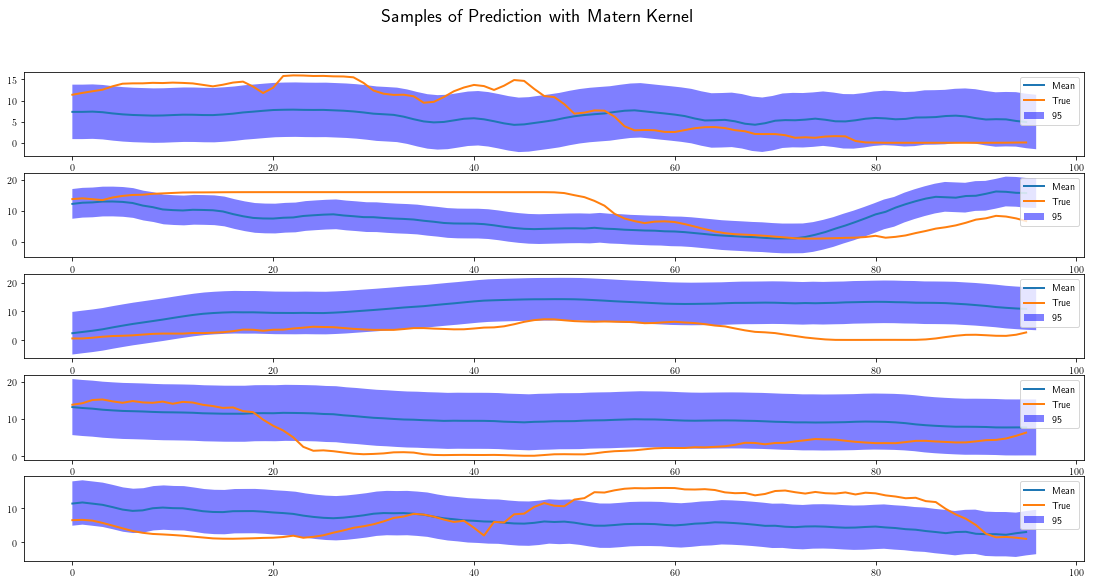

In [81]:
# Look at a couple random predictions against the true values
num_to_plot = 5
rand_inds = np.random.randint(0, test_size, size=num_to_plot)

plt.figure(figsize=(19,9))
plt.suptitle("Samples of Prediction with Matern Kernel", fontsize=19)

for i in range(num_to_plot):
    pred_ind = rand_inds[i]
    single_pred = y_mean[pred_ind,:]

#     plt.figure(figsize=(19,2))
    plt.subplot(num_to_plot, 1, i+1)
    plt.plot(single_pred, label="Mean")
    plt.plot(y_test[pred_ind, :], label="True")

    # # Plot the 95% confidence interval
    vec = np.atleast_2d(np.linspace(0, len(single_pred), len(single_pred))).T
    plt.fill(np.concatenate([vec, vec[::-1]]),
             np.concatenate([single_pred - 1.9600 * y_std[pred_ind],
                            (single_pred + 1.9600 * y_std[pred_ind])[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval');
    plt.legend(loc="upper right");

Note that these confidence bounds aren't actually the right ones. In this library's implementation of GPs, as far as I can tell, you can't get the elementwise variance of each sampled vector. It'll only return the standard deviation associated with the entire sample, so you can't figure out how the confidence changes between elements within the sampled vector. So, for these confidence bounds, I just get the std of the whole sample (i.e. the sampled vector) and use that for the whole sample. Intuitively, though, we would expect the bound to be narrow on the left and get wider towards the right, since it's harder to predict values further into the future.

Time taken to sample 3 scenarios:: 0.0 secs


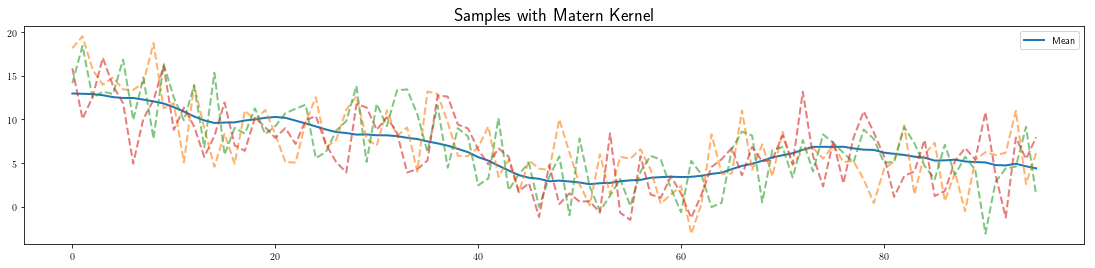

In [114]:
# Now, look at samples taken from the distribution
# Pick a random index to sample:
pred_ind = np.random.randint(0, test_size, size=1)[0]

tic = time()
num_samps = 3
samps = vec_matern_gp.sample_y(X_test[pred_ind, :].reshape(-1,1).T, num_samps)
print("Time taken to sample %d scenarios:: %.1f secs" % (num_samps, time()-tic))

samps = samps.squeeze()

plt.figure(figsize=(19,4))
mean_line = plt.plot(y_mean[pred_ind, :])
for k in range(num_samps):
    plt.plot(samps[:,k], '--', alpha=0.6)
plt.title("Samples with Matern Kernel", fontsize=18)
plt.legend((mean_line), ('Mean',));

Note that for this case, because we sample an entire scenario vector at once, these scenarios *are* internally correlated. As in, each element of a scenario is not independent, which was the case in examples above when the GP only predicted one step into the future at a time. However, these scenarios do generally still just look like noise around the mean, so the fact that they're correlated may not be of much importance for this particular dataset. Presumably, if you got a much bigger dataset (like wind power output of all windfarms in a state) then the correlations would be much more relevant and so realistic scenarios would no longer resemble noise around the predicted mean.

### MPC

### NO SCENARIOS
We first run MPC using this GP as the forecaster without using scenarios. We do this to baseline it to see what the gains of scenarios are, and also to compare it to the vanilla forecaster.

In [115]:
T_MPC = intervals_per_day
K = 20 # Number of scenarios to use

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1) # Changed the second argument from K to 1 so that it doens't use scenarios
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

# Ahead of time, make an indexer which will quickly create the diced array without using a for loop
count_vec = np.arange(2*T_MPC)
indexer = np.zeros((T_MPC, T_MPC), dtype=np.int)
for i in range(indexer.shape[0]):
    indexer[i,:] = count_vec[i:i+T_MPC]
# Now, if you take an array and do arr[indexer], it'll return a matrix with strides taken from the array
# at steps of T_MPC. Assumes the arr is 2*T_MPC long

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T # changed this line to not use K dimension as well
    
    # This call to np.random.multivariate_normal is doing the following:
    # Getting a prediction of the wind T_MPC steps into the future and using that as the mean of the distr
    # Using the sigma_residual_errors as the cov
    # The first entry is known, and then it gets N-1 samples from the distribution
    # Sampling from that distr
    
    # That means all I need to do is get the SAME prediction, and then add samples from my GP distribution
    # to copies of the prediction instead
    
    #### Logan's GP code ####
    # First, get the forecast for the next T_MPC intervals using the GP instead of original forecaster
    forecast = vec_matern_gp.predict(p_wind[sim_start_time+t+1-T_MPC:(sim_start_time+t+1)].values.reshape(1,T_MPC))
#     print(forecast.shape)
#     print(p_wind[sim_start_time+1])
#     print(forecast[:, :-1].shape)
#     print(np.matrix(p_wind[sim_start_time+t]).shape)
#     print(forecast[:, :-1].shape)

    # In this case, simply assign the forecast to the scenarios and don't add anything else
    scenarios = np.concatenate((np.matrix(p_wind[sim_start_time+t]),
                          forecast[:, :-1]), axis=1)

#     scenarios = scenarios.T
#     print(type(scenarios))
    
#     # If adding scenarios:
#     # Then, combine that with data from the past T_MPC intervals and then dice it into a matrix
#     # where each row is the past T_MPC values (real or predicted) leading up to a point. This will
#     # be the input to the GP
#     eval_data = np.concatenate((p_wind[sim_start_time+t-T_MPC:sim_start_time+t], forecast))
#     N = eval_data.shape[0]
#     gp_input = eval_data[indexer]
        
#     # Get some samples of residuals from the GP
#     samps = rbf_gp.sample_y(gp_input, K)
#     samps = samps.T
#     scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T, 
#                           samps[:,:-1]])
    
    #### Logan's GP code ####
    
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    


In [116]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [02:53<00:00, 17.14it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	38.85 MWh
Wind energy used:	152.48 MWh
Wind energy lost:	49.88 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1654.73


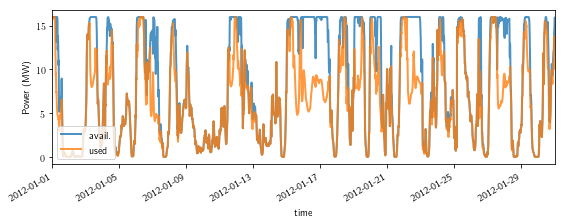

In [117]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

### USING SCENARIOS

In [118]:
T_MPC = intervals_per_day
K = 20

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

# Ahead of time, make an indexer which will quickly create the diced array without using a for loop
count_vec = np.arange(2*T_MPC)
indexer = np.zeros((T_MPC, T_MPC), dtype=np.int)
for i in range(indexer.shape[0]):
    indexer[i,:] = count_vec[i:i+T_MPC]
# Now, if you take an array and do arr[indexer], it'll return a matrix with strides taken from the array
# at steps of T_MPC. Assumes the arr is 2*T_MPC long

def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T

    
    #### Logan's GP code ####
    # Get K samples for the next 96 intervals
    scenarios = vec_matern_gp.sample_y(p_wind[sim_start_time+t+1-T_MPC:(sim_start_time+t+1)].values.reshape(1,T_MPC), n_samples=K).squeeze().T
    scenarios = np.concatenate((np.matrix([p_wind[sim_start_time+t]]*K).T,
                          scenarios[:, :-1]), axis=1)
    

    # It's possible we'd rather have the mean as one of the scenarios, then sample another K-1 scenarios instead
    # of simply sampling K scenarios, but whatever we'll go with this for now
    
    #### Logan's GP code ####
    
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    


In [119]:
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [22:40<00:00,  2.23it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	36.56 MWh
Wind energy used:	154.87 MWh
Wind energy lost:	47.49 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1557.58


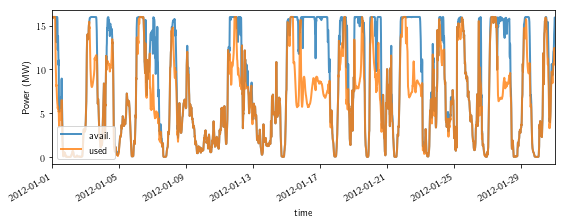

In [120]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)